<a href="https://colab.research.google.com/github/Divyesh-2598/Image-Classification/blob/master/FinalNewCoughRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip -q "/content/train_data.zip"

In [3]:
!unzip -q "/content/Test_data.zip"

replace Test_data/Asthama/NonCough1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from PIL import Image

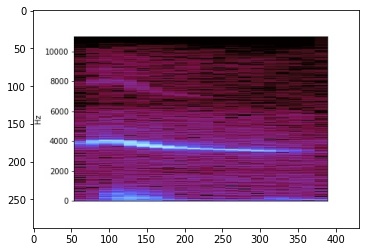

(288, 432, 3)


In [33]:
import cv2
DATADIR = "/content/train_data"
TESTDATADIR = "/content/Test_data"
CATEGORIES = ["Asthama", "NormalCough"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more

print(img_array.shape)

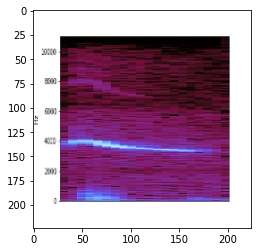

In [34]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [35]:
from tqdm import tqdm
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 1746/1746 [00:04<00:00, 383.05it/s]

2889


In [36]:
import random
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

1
1
0
1
1
0
0
1
1
0


In [37]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)


[[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]]


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [0]:
BS=32
epochs=10
trainAug = ImageDataGenerator(rescale=1./255,zoom_range=0.2,validation_split=0.2)

In [0]:
testAug = ImageDataGenerator(rescale=1. / 255)
#testAug = ImageDataGenerator()

In [0]:
trainAug.fit(X_train)

In [42]:
train_generator = trainAug.flow_from_directory(DATADIR,target_size=(224, 224),batch_size=BS,
                                                    class_mode='sparse', subset='training', shuffle=True)

validation_generator = trainAug.flow_from_directory(DATADIR,target_size=(224, 224),batch_size=BS,
                                                         class_mode='sparse',subset='validation', shuffle=True)

test_generator = testAug.flow_from_directory(TESTDATADIR,target_size=(224,224),batch_size=BS,
                                             class_mode='sparse', shuffle=True)

Found 2312 images belonging to 2 classes.
Found 577 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


In [43]:
from keras import layers
from keras import models
from keras.applications import MobileNet
mobile_model = keras.applications.mobilenet.MobileNet()
mobile_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [44]:
type(mobile_model)

tensorflow.python.keras.engine.training.Model

In [0]:
from tensorflow.keras.models import Sequential
model = Sequential()
for layer in mobile_model.layers[:-1]:
  model.add(layer)

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)     

In [0]:
for layer in model.layers:
  layers.trainable = False

In [0]:
import tensorflow as tf
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
model.add(Dense(2, activation='softmax'))

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)     

In [0]:
from keras import optimizers
#sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.3, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
History = model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames) // BS, epochs=epochs,
                              validation_data=validation_generator, validation_steps=len(validation_generator.filenames) // BS)

Epoch 1/10
72/72 [==============================] - 547s 8s/step - loss: 0.9461 - accuracy: 0.9240 - val_loss: 0.5005 - val_accuracy: 0.9549
Epoch 2/10
72/72 [==============================] - 543s 8s/step - loss: 0.0776 - accuracy: 0.9763 - val_loss: 0.3978 - val_accuracy: 0.9566
Epoch 3/10
72/72 [==============================] - 539s 7s/step - loss: 0.0801 - accuracy: 0.9741 - val_loss: 0.0688 - val_accuracy: 0.9792
Epoch 4/10
72/72 [==============================] - 540s 7s/step - loss: 0.0598 - accuracy: 0.9838 - val_loss: 0.0931 - val_accuracy: 0.9740
Epoch 5/10
72/72 [==============================] - 539s 7s/step - loss: 0.0328 - accuracy: 0.9882 - val_loss: 0.0541 - val_accuracy: 0.9826
Epoch 6/10
72/72 [==============================] - 534s 7s/step - loss: 0.0437 - accuracy: 0.9908 - val_loss: 0.0636 - val_accuracy: 0.9809
Epoch 7/10
72/72 [==============================] - 530s 7s/step - loss: 0.0184 - accuracy: 0.9934 - val_loss: 0.0374 - val_accuracy: 0.9878
Epoch 8/10
72

In [52]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 21s 1s/step - loss: 1.7143 - accuracy: 0.6090


[1.7143040895462036, 0.6089965105056763]

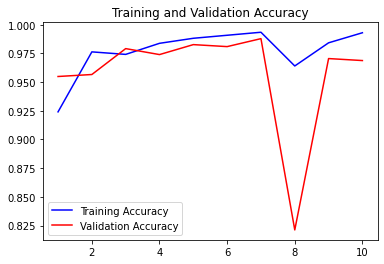

In [53]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

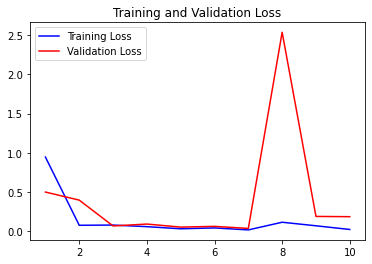

In [54]:
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [0]:
def prepare(filepath):
    IMG_SIZE = 224
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

predictions = model.predict([prepare('/content/test5.jpg')])
print(CATEGORIES[int(predictions[0][0])])

Cough


In [0]:
Y_pred = model.predict_generator(test_generator, steps=143//BS+1)
#Y_pred = model.predict(X_test)

In [0]:
y_pred = np.argmax(Y_pred, axis=1)

In [57]:
from sklearn.metrics import confusion_matrix
print(y_pred)
print('Confusion Matrix')
a=test_generator.classes
print(a)
confusion_matrix=confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix)

[1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0
 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1
 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1]
Confusion Matrix
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[20 45]
 [25 53]]


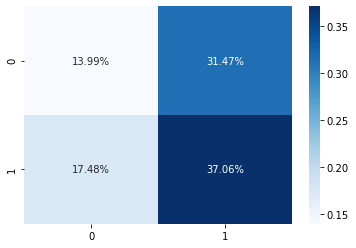

In [58]:
import seaborn as sns
#categories=['Cough','NonCough']
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [0]:
model.save('NewCoughRecognition.hdf5')

In [0]:
import cv2
import librosa
from librosa import display
import os
import numpy as np
import pylab
import glob
import matplotlib.pyplot as plt

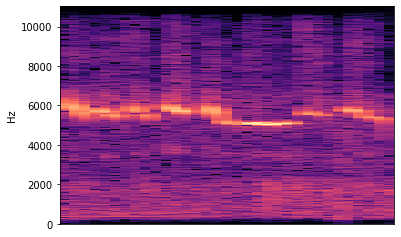

In [0]:
name='test5'
y, sr = librosa.load('/content/Rec_2020_04_28_12_26_2625.WAV')
y = librosa.resample(y, sr, 8000)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
save_path = name + '.jpg'
pylab.savefig(save_path, bbox_inches=None, pad_inches=0)

In [0]:
!unzip -q "/content/Test.zip"

In [0]:
import cv2
import librosa
from librosa import display
import os
import numpy as np
import pylab
import glob
import matplotlib.pyplot as plt
data_dir = "/content/Test/Cough"
audio_files = glob.glob(data_dir + '/*.wav')
len(audio_files)

5

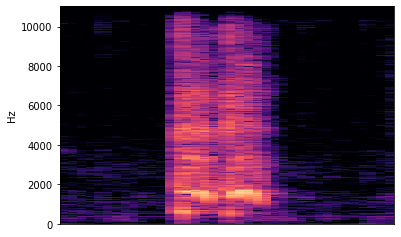

In [0]:
image_no=74
name='Cough'
for i in range(len(audio_files)):
  y, sr = librosa.load(audio_files[i])
  y = librosa.resample(y, sr, 8000)
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
  librosa.display.specshow(D, y_axis='linear')
  save_path = name + str(image_no) + '.jpg'
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  image_no += 1

In [0]:
!bash -c 'mv Cough{1..78}.jpg /content/Test_data/Cough'

In [0]:
!zip -r /content/Test_data.zip /content/Test_data

  adding: content/Test_data/ (stored 0%)
  adding: content/Test_data/.ipynb_checkpoints/ (stored 0%)
  adding: content/Test_data/NonCough/ (stored 0%)
  adding: content/Test_data/NonCough/NonCough22.jpg (deflated 2%)
  adding: content/Test_data/NonCough/NonCough55.jpg (deflated 4%)
  adding: content/Test_data/NonCough/NonCough20.jpg (deflated 3%)
  adding: content/Test_data/NonCough/NonCough56.jpg (deflated 4%)
  adding: content/Test_data/NonCough/NonCough29.jpg (deflated 2%)
  adding: content/Test_data/NonCough/NonCough5.jpg (deflated 2%)
  adding: content/Test_data/NonCough/NonCough49.jpg (deflated 3%)
  adding: content/Test_data/NonCough/NonCough46.jpg (deflated 2%)
  adding: content/Test_data/NonCough/NonCough19.jpg (deflated 3%)
  adding: content/Test_data/NonCough/NonCough17.jpg (deflated 2%)
  adding: content/Test_data/NonCough/NonCough35.jpg (deflated 2%)
  adding: content/Test_data/NonCough/NonCough53.jpg (deflated 3%)
  adding: content/Test_data/NonCough/NonCough10.jpg (defla